# MACD Trading 

Strategy: MACD cross using the 12/26/9 setup, Place a buy signal when the MACD line crosses above the signal line, and place a sell signal when it crosses below. \
Definition: 1. MACD line = 12 days EMA - 26 days EMA, \
2. signal line = 9 days EMA of the MACD line. \
Stock to backtest: IBM \
Data source: yahoo finance \
Tool: Python 

In [171]:
# ========== LIBRARY ==========
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ========== PARAMETERS ==========
TICKER = "IBM"
START = '2010-01-01'
END = '2025-01-01'
FAST = 12
SLOW = 26
SIGNAL = 9

INITIAL_CAPITAL = 10000.0
POSITION_SIZE_PER_TRADE = None
SHARE_PER_TRADE = None
TRANSACTION_COST_PER_TRADE = 0.005
SLIPPAGE_PCT = 0.0

# ========== DATA ==========
df = yf.download(TICKER, start=START, end=END, progress=False)
df = df.dropna()
price = df['Close']

# ========== INDICATORS ==========
ema_fast = price.ewm(span=FAST, adjust=False).mean()
ema_slow = price.ewm(span=SLOW, adjust=False).mean()
MACD = ema_fast - ema_slow
signal = MACD.ewm(span=SIGNAL, adjust=False).mean()
histogram = MACD - signal

df = df.assign(price = price, ema_fast = ema_fast, ema_slow = ema_slow, MACD = MACD, signal = signal, histogram = histogram)

# ========== SIGNAL ==========
# Denote the cross as the trade signal
df['macd_cross'] = df['MACD'] > df['signal'] 
df['singal_change'] = df['macd_cross'].astype(int).diff() # +1 when MACD is crossed above the singal line, -1 when vice versa
df['singal_change'] = df['singal_change'].fillna(0)
df['next_day'] = df['Open'].shift(-1) #Excute the trade at the beginning of the next trading day


C:\Users\desti\AppData\Local\Temp\ipykernel_7736\164225917.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


In [172]:
# ========== Simulation ==========
cash = INITIAL_CAPITAL
position = 0
trade_log = []

for idx, row in df.iterrows():
    sig = row['singal_change'].item()
    exec_price = row['next_day'].item() # execute on the next day open price
    if pd.isna(exec_price):
        continue

    # Buy Signal
    if sig == 1:
        # Determine the position size
        if SHARE_PER_TRADE is not None:
            shares_to_buy = SHARE_PER_TRADE # use fixed amount of shares to trade
        if POSITION_SIZE_PER_TRADE is not None:
            shares_to_buy = int(POSITION_SIZE_PER_TRADE/ exec_price) # used fixed amount of capitial to trade
        else: # all-in
            shares_to_buy = int(cash/exec_price)
        if shares_to_buy > 0:
            cost = exec_price * shares_to_buy
            effective_price = exec_price * (1 + SLIPPAGE_PCT) # market traded price
            tc_adj_cost = effective_price * shares_to_buy + shares_to_buy * TRANSACTION_COST_PER_TRADE
            if cash > tc_adj_cost:
                cash -= tc_adj_cost
                position += shares_to_buy
                trade_log.append({'date': idx, 'type': "buy", 'price': effective_price, 'shares': shares_to_buy, 'cash': cash})

     # sell Signal (sell all)
    elif sig == -1 and position > 0:
        shares_to_sell = position
        effective_price = exec_price *(1 - SLIPPAGE_PCT)
        proceeds = effective_price * shares_to_sell + shares_to_sell * TRANSACTION_COST_PER_TRADE
        cash += proceeds
        trade_log.append({'date': idx,'type': "sell",'price': effective_price, 'shares': shares_to_sell, 'cash':cash})
        position = 0

# Finally, mark-to-market portfolio value
last_pos = 0
pos_by_date = []
trade_iter = iter(trade_log)
next_trade = None
try:
    next_trade = next(trade_iter)
except StopIteration:
    next_trade = None

cash = INITIAL_CAPITAL
position = 0
equity = [] # Stock market value + cash

for idx, row in df.iterrows():
    # apply trade to date that have idx
    while next_trade is not None and next_trade['date'] == idx:
        if next_trade['type'] == 'buy':
            position += next_trade['shares']
            cash = next_trade['cash']
        else:
            position -= next_trade['shares']
            cash = next_trade['cash']
        try:
            next_trade = next(trade_iter)
        except StopIteration:
            next_trade = None
    # mark to mkt portfolio value with close price
    mkt_value = cash + position * row['Close'].item()
    equity.append(mkt_value)

df = df.iloc[:len(equity)].copy()
df['equity'] = equity
df['return'] = df['equity'].pct_change().fillna(0)


Date          2010-01-04  2010-01-05  2010-01-06  2010-01-07  2010-01-08  \
Total Return         0.0         0.0         0.0         0.0         0.0   
Annualized           0.0         0.0         0.0         0.0         0.0   
Sharpe Ratio         0.0         0.0         0.0         0.0         0.0   

Date          2010-01-11  2010-01-12  2010-01-13  2010-01-14  2010-01-15  ...  \
Total Return         0.0         0.0         0.0         0.0    0.001068  ...   
Annualized           0.0         0.0         0.0         0.0    0.000071  ...   
Sharpe Ratio         0.0         0.0         0.0         0.0    0.000474  ...   

Date          2024-12-17  2024-12-18  2024-12-19  2024-12-20  2024-12-23  \
Total Return    2.164657    2.164657    2.164657    2.164657    2.164657   
Annualized      0.079961    0.079961    0.079961    0.079961    0.079961   
Sharpe Ratio    0.531509    0.531509    0.531509    0.531509    0.531509   

Date          2024-12-24  2024-12-26  2024-12-27  2024-12-30  202

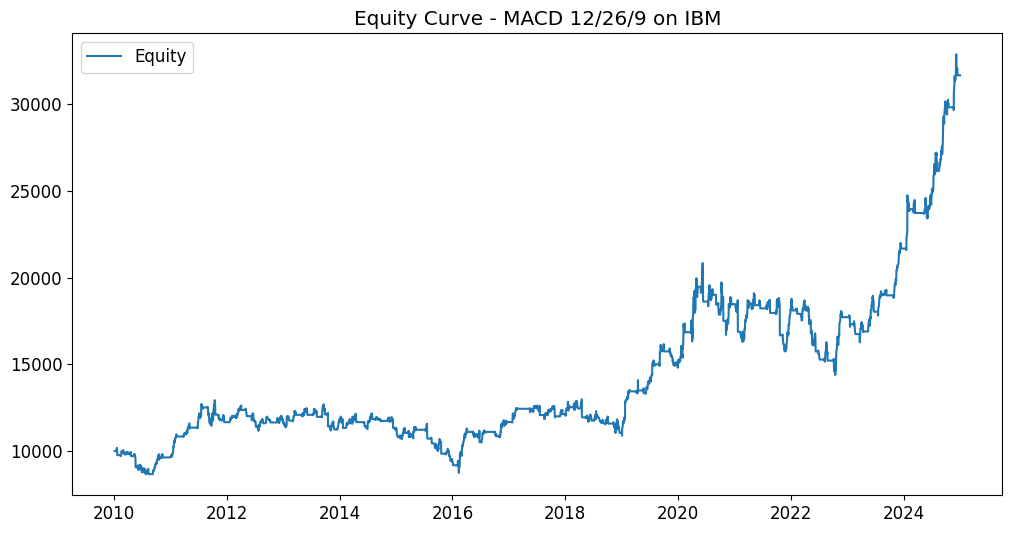

[{'cash': 21.654554512206232,
  'date': Timestamp('2010-01-15 00:00:00'),
  'price': 72.82963828823208,
  'shares': 137,
  'type': 'buy'},
 {'cash': 9775.630530505756,
  'date': Timestamp('2010-01-21 00:00:00'),
  'price': 71.19190493425948,
  'shares': 137,
  'type': 'sell'},
 {'cash': 56.044016992409524,
  'date': Timestamp('2010-02-12 00:00:00'),
  'price': 69.42061795366675,
  'shares': 140,
  'type': 'buy'},
 {'cash': 9837.876168852026,
  'date': Timestamp('2010-03-10 00:00:00'),
  'price': 69.86522965614012,
  'shares': 140,
  'type': 'sell'},
 {'cash': 27.050125724537793,
  'date': Timestamp('2010-03-11 00:00:00'),
  'price': 71.08794234150353,
  'shares': 138,
  'type': 'buy'},
 {'cash': 9873.919761028972,
  'date': Timestamp('2010-04-01 00:00:00'),
  'price': 71.34912779206111,
  'shares': 138,
  'type': 'sell'},
 {'cash': 4.040174771693273,
  'date': Timestamp('2010-04-05 00:00:00'),
  'price': 71.51586656708173,
  'shares': 138,
  'type': 'buy'},
 {'cash': 9824.837881991674,

In [ ]:
# ========== Performance ==========
total_return = df['equity']/INITIAL_CAPITAL - 1
ann_return = (1 + total_return) ** (252.0/len(df)) - 1
ann_vol = df['return'].std() * np.sqrt(252)
sharpe = (ann_return/ann_vol) if ann_vol != 0 else np.nan
running_max = df['equity'].cummax()
drawdown = (df['equity'] - running_max) / running_max
Max_DD = drawdown.min()

new_df = pd.DataFrame({'Total Return': total_return, 'Annualized': ann_return, 'Sharpe Ratio': sharpe, 'Maximum Drawdown': Max_DD}).T # Transpose to get Series as columns
print(new_df.head(3), new_df.tail(3))

print("Final trading day result", df['equity'].iloc[-1])

# ========== PLOT ==========
%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(df.index, df['equity'], label='Equity')
plt.title(f"Equity Curve - MACD {FAST}/{SLOW}/{SIGNAL} on {TICKER}")
plt.legend()
plt.show()

# ========== Trade Log ==========
import pprint
pprint.pprint(trade_log[:20])

## Backtrader Simulation

In [174]:
# Import library and set parameters
import backtrader as bt
import yfinance as yf
import pandas as pd
import datetime as datetime
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo

# -------------------------------
# Fetch IBM historical data
# -------------------------------
df = yf.download("IBM", start="2020-01-01", end="2023-01-01")
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)

# -------------------------------
# PARAMETERS 
# -------------------------------
TICKER = "IBM"
START = '2010-01-01'
END = '2025-01-01'
FAST = 12
SLOW = 26
SIGNAL = 9

C:\Users\desti\AppData\Local\Temp\ipykernel_7736\3746925799.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("IBM", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [175]:
# -------------------------------
# Define MACD Strategy
# -------------------------------
class MACDStrategy(bt.Strategy):
    params = dict(fast=12, slow=26, signal=9, stake=100)

    def __init__(self):
        # Define MACD line
        self.macd = bt.ind.MACD(self.data.close, 
                                period_me1=self.p.fast, 
                                period_me2=self.p.slow, 
                                period_signal=self.p.signal)

        # Create cross line
        self.crossover = bt.ind.CrossOver(self.macd.macd, self.macd.signal)

        # Plot MACD, singal and Histogram
        self.macd_line = bt.indicators.MACD(self.data.close,
                                            period_me1=self.p.fast,
                                            period_me2=self.p.slow,
                                            period_signal=self.p.signal)
        self.signal_line = self.macd_line.signal

        # Plot MACD, signal, histogram on a seperate subplot
        self.macd_line.plotinfo.subplot = True
    

    def next(self):
        if not self.position:
            if self.crossover > 0:
                # Buy at the next bar open
                size = self.p.stake
                self.buy(size=size)
        else:
            if self.crossover <0:
                size = self.p.stake
                self.close()

# -------------------------------
# Custom Analyzer: Sharpe Ratio
# -------------------------------
class SharpeRatio(bt.Analyzer):
    def __init__(self):
        self.returns = []
    
    def next(self):
        if len(self.data) > 1:
            ret = (self.data.close[0] / self.data.close[-1]) - 1
            self.returns.append(ret)

    def get_analysis(self):
        arr = np.array(self.returns)
        sharpe = np.mean(arr) / np.std(arr) * np.sqrt(252) if np.std(arr) != 0 else 0
        return {'Sharpe': sharpe}
    
# -------------------------------
# Custom Analyzer: Maximum DrawDown
# -------------------------------
class Max_DD(bt.Analyzer):
    def __init__(self):
        self.max_value = -np.inf
        self.maxdd = 0
    
    def next(self):
        value = self.strategy.broker.getvalue()
        if value > self.max_value:
            self.max_value = value
        dd = (self.max_value - value) / self.max_value
        self.maxdd = max(self.maxdd, dd)

    def get_analysis(self):
        return {'Maximum DrawDown': self.maxdd}

[*********************100%***********************]  1 of 1 completed


Initial portfolio value:  10000
Final portfolio value:  23989.37842727656
Total PnL: -76,010.62
Sharpe Ratio: OrderedDict([('sharperatio', 0.38860928570998754)])
Drawdown: AutoOrderedDict([('len', 16), ('drawdown', 3.5182449026313507), ('moneydown', 874.7820588865106), ('max', AutoOrderedDict([('len', 1955), ('drawdown', 35.359045770200616), ('moneydown', 4459.295818057432)]))])
Returns: OrderedDict([('rtot', 0.8750260738627285), ('ravg', 0.00023185640536903246), ('rnorm', 0.06016845377456736), ('rnorm100', 6.016845377456736)])
TradeAnalyzer: AutoOrderedDict([('total', AutoOrderedDict([('total', 106), ('open', 0), ('closed', 106)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 6), ('longest', 6)])), ('lost', AutoOrderedDict([('current', 0), ('longest', 7)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 15108.403593317758), ('average', 142.53210937092226)])), ('net', AutoOrderedDict([('total', 13989.378427276548), ('average', 131.97526818185423)

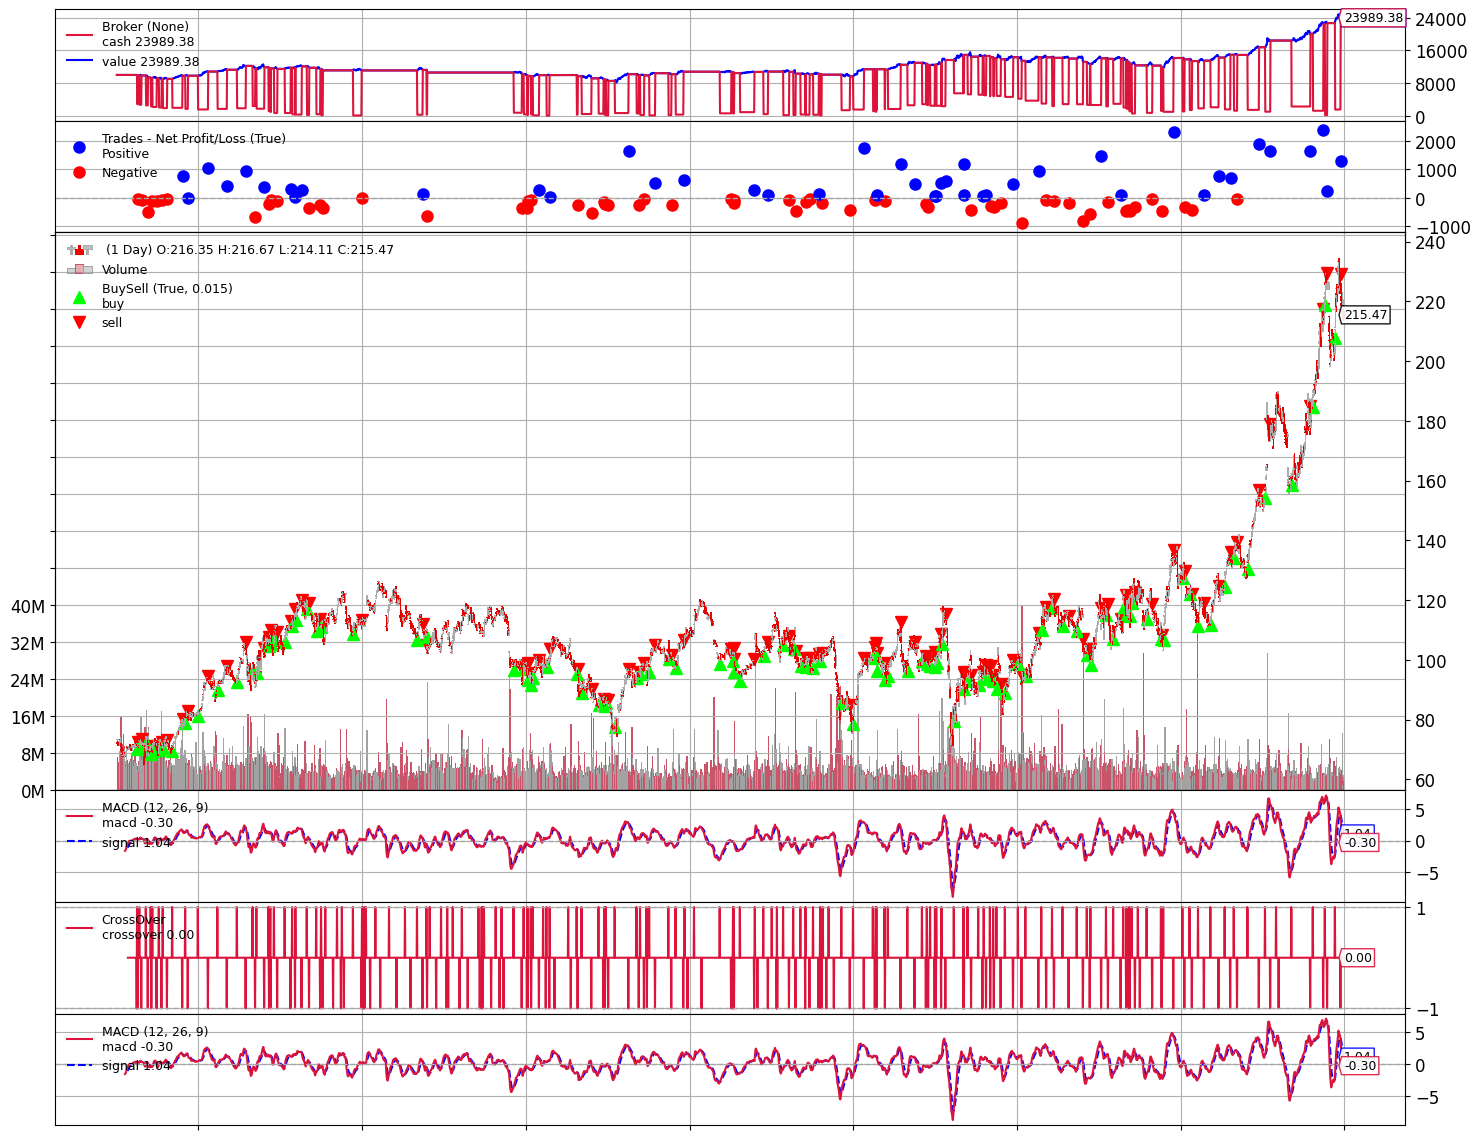

[[<Figure size 1500x1200 with 7 Axes>]]

In [181]:
# -------------------------------
# Run Backtest
# -------------------------------
cerebro = bt.Cerebro()
cerebro.addstrategy(MACDStrategy)

# Data feed
df = yf.download(TICKER, START, END, auto_adjust=True)
if isinstance(df.columns, pd.MultiIndex):
    df = df.xs(TICKER, level=1, axis=1)

data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

# Initial Capital
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission = 0.0005)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="tradeanalyzer")

# Performance
print('Initial portfolio value: ', cerebro.broker.getvalue())
cerebro.run()
final_value = cerebro.broker.getvalue()
print('Final portfolio value: ', final_value)
pnl = final_value - 100000

print(f"Total PnL: {pnl:,.2f}")
print(f'Sharpe Ratio: {cerebro.run()[0].analyzers.sharpe.get_analysis()}')
print(f'Drawdown: {cerebro.run()[0].analyzers.drawdown.get_analysis()}')
print(f'Returns: {cerebro.run()[0].analyzers.returns.get_analysis()}')
print(f'TradeAnalyzer: {cerebro.run()[0].analyzers.tradeanalyzer.get_analysis()}')

# -------------------------------
# Plot MACD & Price
# -------------------------------
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(style= 'candlestick', iplot = False)